# Implementing the BYM2 for Disconnected Graphs

## Notebook Setup

Import all libraries, load the NYC study data.

In [1]:
# import all libraries used in this notebook
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as sa
import matplotlib
import splot as splt
from splot.libpysal import plot_spatial_weights 
import plotnine as p9
import arviz as az
%matplotlib inline

from cmdstanpy import CmdStanModel, cmdstan_path, cmdstan_version, write_stan_json

# suppress plotnine warnings
import warnings
warnings.filterwarnings('ignore')

# setup plotnine look and feel
p9.theme_set(
  p9.theme_grey() + 
  p9.theme(text=p9.element_text(size=10),
        plot_title=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=12),
        axis_title_y=p9.element_text(size=12),
        axis_text_x=p9.element_text(size=8),
        axis_text_y=p9.element_text(size=8)
       )
)
xlabels_90 = p9.theme(axis_text_x = p9.element_text(angle=90, hjust=1))

map_theme =  p9.theme(figure_size=(7,6),
                 axis_text_x=p9.element_blank(),
                 axis_ticks_x=p9.element_blank(),
                 axis_text_y=p9.element_blank(),
                 axis_ticks_y=p9.element_blank())

In [2]:
nyc_geodata = gpd.read_file(os.path.join('data', 'nyc_study.geojson'))
nyc_geodata.columns

Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2010', 'BoroCT2010', 'CDEligibil',
       'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area', 'BoroFips',
       'ct2010full', 'kids_per_sq_mi', 'count', 'kid_pop', 'pct_pubtransit',
       'med_hh_inc', 'traffic', 'frag_index', 'geometry'],
      dtype='object')

number of components: 8
islands? [328, 1860, 1903]
max number of neighbors per node: 12
mean number of neighbors per node: 4.926968973747017


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

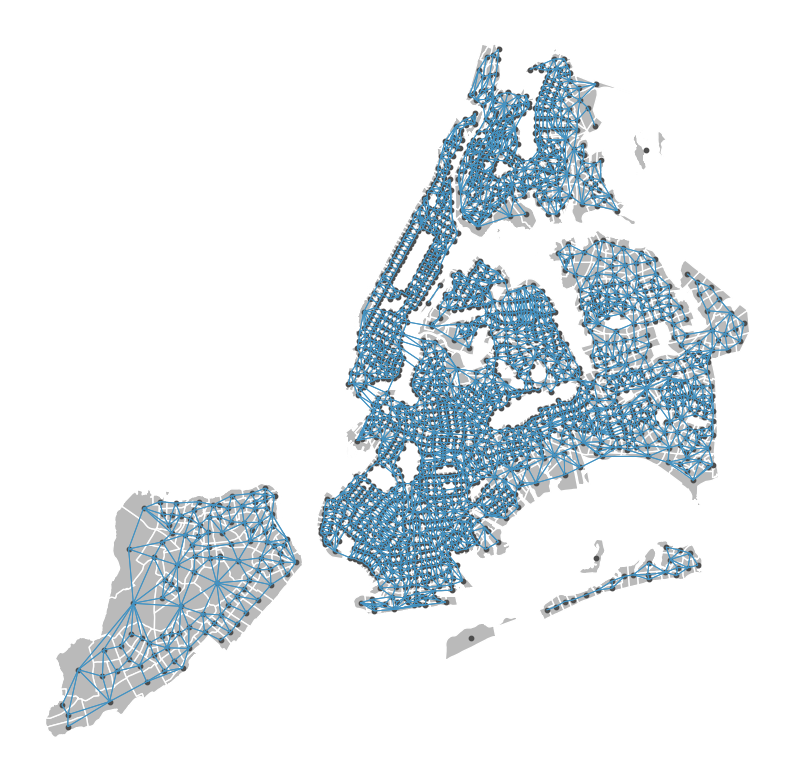

In [3]:
nyc_nbs = sa.weights.Rook.from_dataframe(nyc_geodata, geom_col='geometry')
print(f'number of components: {nyc_nbs.n_components}')
print(f'islands? {nyc_nbs.islands}')
print(f'max number of neighbors per node: {nyc_nbs.max_neighbors}')
print(f'mean number of neighbors per node: {nyc_nbs.mean_neighbors}')
plot_spatial_weights(nyc_nbs, nyc_geodata)

In [4]:
bym2_islands_model_file = os.path.join('stan', 'bym2_islands.stan')

In [5]:
with open(bym2_islands_model_file, 'r') as file:
    contents = file.read()
    print(contents)

functions {
  /**
   * Compute ICAR, use soft-sum-to-zero constraint for identifiability
   *
   * @param phi vector of varying effects
   * @param adjacency parallel arrays of indexes of adjacent elements of phi
   * @param singletons array of indexes of singleton nodes
   * @param epsilon allowed variance for soft centering
   * @return ICAR log probability density
   * @reject if the the adjacency matrix does not have two rows
   */
  real standard_icar_lpdf(vector phi,
			  array[ , ] int adjacency,
			  array[] int singletons,
			  real epsilon) {
    if (size(adjacency) != 2)
      reject("require 2 rows for adjacency array;",
             " found rows = ", size(adjacency));

    return -0.5 * dot_self(phi[adjacency[1]] - phi[adjacency[2]])
      + normal_lpdf(phi[singletons] | 0, 1)
      + normal_lpdf(sum(phi) | 0, epsilon * rows(phi));
  }
}
data {
  int<lower=0> N;
  array[N] int<lower=0> y; // count outcomes
  vector<lower=0>[N] E; // exposure
  int<lower=1> K; // num covari

## Data Prep

### Get edgeset

- Compute this automatically from `nyc_geodata` spatial geometry component
  + Python package `libpysal`
  + R package `spdep`

In [6]:
nyc_nbs_adj =  nyc_nbs.to_adjlist(remove_symmetric=True)

In [7]:
# create np.ndarray from columns in adjlist, increment indices by 1
j1 = nyc_nbs_adj['focal'] + 1
j2 = nyc_nbs_adj['neighbor'] + 1
edge_pairs = np.vstack([j1, j2])
singleton_ids = nyc_nbs.islands

In [8]:
for n in range(0, len(singleton_ids)) :
    singleton_ids[n] += 1

### Compute scaling factor `tau`

Scaling factor for singletons is 1, Scaling factor for multi-node component is computed as before

* Compute cardinality of each component

In [38]:
id = nyc_nbs.component_labels
(comp_id, counts) = np.unique(ids, return_counts = True)
counts

array([ 329,    1, 1631,    2,    1,   22,    1,  108])

* Get subset of regions for multi-node components

In [39]:
nyc_geodata['comp_id'] = id

In [49]:
comp_1 = nyc_geodata[nyc_geodata['comp_id']==0]
comp_1_nbs = sa.weights.Rook.from_dataframe(comp_1, geom_col='geometry')
comp_1_nbs.islands

comp_3 = nyc_geodata[nyc_geodata['comp_id']==2]
comp_3_nbs = sa.weights.Rook.from_dataframe(comp_2, geom_col='geometry')
comp_3_nbs.islands


comp_6 = nyc_geodata[nyc_geodata['comp_id']==6]
comp_6_nbs = sa.weights.Rook.from_dataframe(comp_6, geom_col='geometry')
comp_6_nbs.islands


comp_8 = nyc_geodata[nyc_geodata['comp_id']==8]
comp_8_nbs = sa.weights.Rook.from_dataframe(comp_8, geom_col='geometry')
comp_8_nbs.islands

[]

* Compute scaling_factor  (or do this in R)

* Scale each region according to scaling factor for the component they belong to.

In [9]:
tau = np.array([0.6, 1, 0.8, 1, 1, 1, 1, 1])
taus = tau[nyc_nbs.component_labels]

#### Assemble the input data 

In [10]:
design_vars = np.array(['pct_pubtransit','med_hh_inc', 'traffic', 'frag_index'])

design_mat = nyc_geodata[design_vars].to_numpy()
design_mat[:, 1] = np.log(design_mat[:, 1])
design_mat[:, 2] = np.log(design_mat[:, 2])

pd.DataFrame(data=design_mat).describe()

,0,1,2,3
count,2095.000000,2095.000000,2095.000000,2.095000e+03
mean,0.697427,10.862932,10.053935,5.250597e-07
std,0.191031,0.485851,0.913035,2.677234e+00
min,0.097700,9.140669,6.736967,-6.728700e+00
25%,0.561000,10.561629,9.420682,-1.818600e+00
50%,0.739100,10.894552,9.861519,-1.085000e-01
75%,0.854050,11.197235,10.524091,1.436550e+00
max,1.000000,12.355639,12.529879,1.867200e+01


In [11]:
bym2_islands_data = {
    "N":nyc_geodata.shape[0],
    "y":nyc_geodata['count'].astype('int'),
    "E":nyc_geodata['kid_pop'].astype('int'),
    "K":4,
    "xs":design_mat,
    "N_edges": edge_pairs.shape[1],
    "neighbors": edge_pairs,
    "taus": taus,
    "N_singletons" : len(singleton_ids),
    "singletons":singleton_ids
}

## Fitting the ICAR Model on the nyc data

#### Model is compiled (as needed) on instantiation 

In [12]:
bym2_islands_mod = CmdStanModel(stan_file=bym2_islands_model_file)

00:05:50 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/workshops/geomed_2024/stan/bym2_islands.stan to exe file /Users/mitzi/github/zmorris/workshops/geomed_2024/stan/bym2_islands
00:05:54 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/workshops/geomed_2024/stan/bym2_islands


#### Run Pathfinder to get initial parameter values

see CmdStanPy notebook: [Using Variational Estimates to Initialize the NUTS-HMC Sampler](https://mc-stan.org/cmdstanpy/users-guide/examples/VI%20as%20Sampler%20Inits.html#Using-Variational-Estimates-to-Initialize-the-NUTS-HMC-Sampler)


In [13]:
bym2_islands_pathfinder = bym2_islands_mod.pathfinder(data=bym2_islands_data)

00:06:02 - cmdstanpy - INFO - Chain [1] start processing
00:06:06 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
param_inits = bym2_islands_pathfinder.create_inits()

In [15]:
bym2_islands_fit = bym2_islands_mod.sample(
    data=bym2_islands_data, iter_warmup=2000,
    inits=param_inits)

00:06:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:07:02 - cmdstanpy - INFO - CmdStan done processing.


In [16]:
bym2_islands_fit.summary().round(2).loc[
  ['beta_intercept', 'beta0', 'betas[1]', 'betas[2]', 'betas[3]', 'betas[4]', 'sigma', 'rho']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
beta_intercept,-7.48,0.03,0.75,-8.71,-7.49,-6.23,529.95,8.95,1.00
beta0,-4.47,0.00,0.02,-4.50,-4.47,-4.45,3452.38,58.31,1.00
betas[1],0.99,0.01,0.22,0.63,0.99,1.34,335.21,5.66,1.02
betas[2],0.17,0.00,0.06,0.06,0.17,0.26,548.18,9.26,1.00
betas[3],0.05,0.00,0.02,0.02,0.05,0.09,2164.95,36.57,1.00
betas[4],0.08,0.00,0.01,0.06,0.08,0.10,801.23,13.53,1.01
sigma,0.75,0.00,0.02,0.72,0.75,0.79,299.95,5.07,1.02
rho,0.40,0.00,0.06,0.31,0.40,0.50,180.69,3.05,1.02


#### Does pathfinder help?

In [17]:
bym2_islands_fit_default_inits = bym2_islands_mod.sample(
    data=bym2_islands_data, iter_warmup=2000)

00:07:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:08:17 - cmdstanpy - INFO - CmdStan done processing.


In [18]:
bym2_islands_fit_default_inits.summary().round(2).loc[
  ['beta_intercept', 'beta0', 'betas[1]', 'betas[2]', 'betas[3]', 'betas[4]', 'sigma', 'rho']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
beta_intercept,-7.55,0.03,0.74,-8.80,-7.53,-6.33,607.30,9.89,1.01
beta0,-4.47,0.00,0.02,-4.50,-4.47,-4.45,3131.51,51.01,1.00
betas[1],1.01,0.01,0.22,0.64,1.01,1.36,283.15,4.61,1.01
betas[2],0.17,0.00,0.06,0.08,0.17,0.27,627.10,10.22,1.00
betas[3],0.05,0.00,0.02,0.02,0.05,0.09,2408.67,39.24,1.00
betas[4],0.08,0.00,0.01,0.06,0.08,0.10,861.64,14.04,1.00
sigma,0.76,0.00,0.02,0.72,0.76,0.80,249.35,4.06,1.02
rho,0.41,0.00,0.06,0.31,0.41,0.50,171.64,2.80,1.02


### Visualize fit

<Axes: xlabel='y / y_rep'>

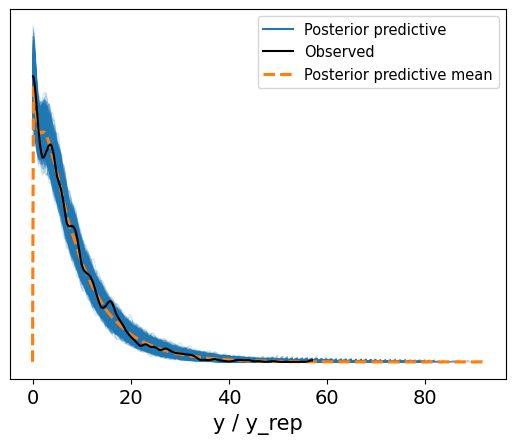

In [19]:
idata_bym2_islands = az.from_cmdstanpy(
    bym2_islands_fit,
    posterior_predictive="y_rep",
    dims={"betas": ["covariates"]},
    coords={"covariates": design_vars},
    observed_data={"y": bym2_islands_data['y']}
)
idata_bym2_islands

az.plot_ppc(idata_bym2_islands, data_pairs={"y":"y_rep"})